#  Улучшению качества сжатых изображений
Студент - Петухов Максим, группа - М4145

## Анализ

Заметим, что данных для обучения очень мало, всего 200 картинок в тренировочной выборке. В лабораторной было предложено обучать не на целых изображениях, а на их патчах размера 40x40 с частотой дискретизации 20. Однако в ходе экспериментов данный подход не позволял обучить нейронную сеть достаточного качества, что скорей всего связано с отстутсвием достаточного количества структурной информацией в патче. Было принято решение обучаться на целых изображениях, однако всвязи с малым их количеством, были приняты следующие решения:
1. Добавить парные аугментации (аугментации которые применяются идентично к сжатому и исходному изображению)
2. Использовать небольшую архитектуру сети, так как более тяжелые модели не смогут обобщиться на таком количестве данных (даже с использованием аугментаций), а просто запомнят тренировочную выборку и будут показывать плохое качество на тесте.

## Аугментации

Было принято решение ограничиться только геометрическими и фотометрическими аугментациями (которые не меняют структурные паттерны в изображениях)

### Загрузим данные

Исходно в коде лабороторной работы считывание директорий сжатых и исходных изображений происходило независимо и порядок чтения задавался функцию os.listdir()

Это могло привести к двум негативному эффекту - могло быть не соотвествие между сжатым и исходным изображениям (могли относится к разным изображениям)

Также при использовании патчей, считывание подряд без последующего перемешивания могло привести к нестабильности в обучении, так как в одном батче находились бы патчи из одного изображения (домена) и на каждой итерации сеть бы видела разные домена и металась бы из стороны в сторону

In [1]:
#test folders for raw and compressed in yuv and png formats
testfolderRawYuv = './testrawyuv/'
testfolderRawPng = './testrawpng/'
testfolderCompYuv = './testcompyuv/'
testfolderCompPng = './testcomppng/'

#train folders for raw and compressed in yuv and png formats
trainfolderRawYuv = './trainrawyuv/'
trainfolderRawPng = './trainrawpng/'
trainfolderCompYuv = './traincompyuv/'
trainfolderCompPng = './traincomppng/'

In [2]:
import cv2
import PIL
import numpy as np
import torch.nn as nn
import torch.optim
import random
import os
from PIL import Image
from numpy import *


def LoadImagesFromFolder(foldername, dir_list):
    N = 0
    Nmax = 0
    for name in dir_list:
        fullname = foldername + name
        Nmax = Nmax + 1

    x = np.zeros([Nmax, 320, 480, 3])
    N = 0
    for name in dir_list:
        fullname = foldername + name
        I1 = cv2.imread(fullname)
        x[N, :, :, 0] = I1[:, :, 2]
        x[N, :, :, 1] = I1[:, :, 1]
        x[N, :, :, 2] = I1[:, :, 0]
        N = N + 1
    return x



print('Loading raw train images...')
train_dir_list = os.listdir(trainfolderRawPng)
random.shuffle(train_dir_list)
Xraw = LoadImagesFromFolder(trainfolderRawPng, train_dir_list)
print('Loading compressed train images...')
Xcomp = LoadImagesFromFolder(trainfolderCompPng, train_dir_list)
Xraw = Xraw/255.0
Xcomp = Xcomp/255.0

print('Loading raw validiation images...')
val_dir_list = os.listdir(testfolderRawPng)
XrawVal = LoadImagesFromFolder(testfolderRawPng, val_dir_list)
print('Loading compressed validiation images...')
XcompVal = LoadImagesFromFolder(testfolderCompPng, val_dir_list)
XrawVal = XrawVal / 255.0
XcompVal = XcompVal / 255.0

Loading raw train images...
Loading compressed train images...
Loading raw validiation images...
Loading compressed validiation images...


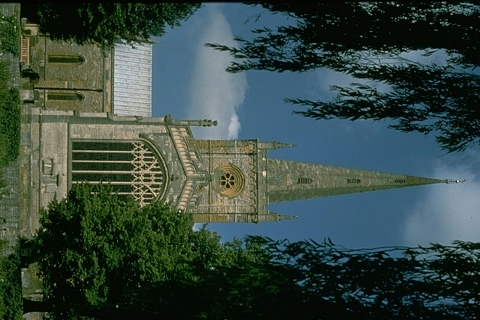

In [3]:
Image.fromarray((Xraw[0] * 255).astype(np.uint8))

### Flipping

In [4]:
import torchvision.transforms.functional as TF
import torchvision.transforms.v2.functional as TFV2
from torchvision.transforms import v2

Горизонтальный

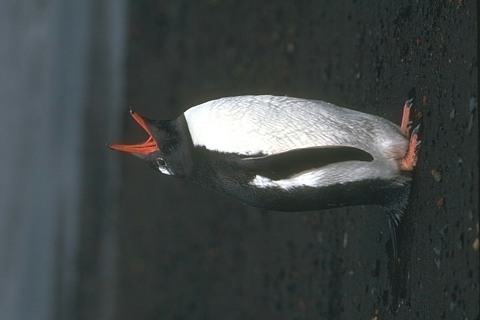

In [12]:
TF.hflip(Image.fromarray((Xraw[0] * 255).astype(np.uint8)))

Вертикальный

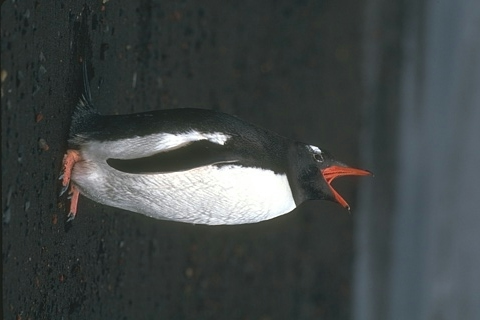

In [13]:
TF.vflip(Image.fromarray((Xraw[0] * 255).astype(np.uint8)))

### Аффинные трансформации

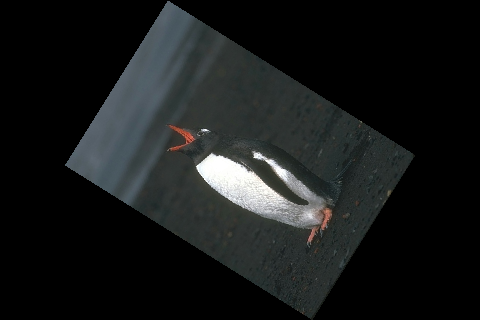

In [20]:
angle = random.randint(0, 360)
translate = (random.randint(100, 300) / 1000, random.randint(100, 300) / 1000)
scale = random.randint(500, 700)  / 1000

TFV2.affine(Image.fromarray((Xraw[0] * 255).astype(np.uint8)), angle=angle, translate=translate, scale=scale, shear=(0.0, 0.0))



### ColorJitter

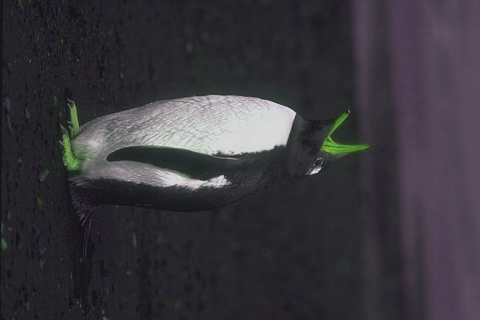

In [28]:
img = Image.fromarray((Xraw[0] * 255).astype(np.uint8))
jitter = v2.ColorJitter(brightness=.5, hue=.3)

brightness = jitter._check_input(.5, "brightness")
contrast = jitter._check_input(0, "contrast")
saturation = jitter._check_input(0, "saturation")
hue = jitter._check_input(.3, "hue", center=0, bound=(-0.5, 0.5), clip_first_on_zero=False)


fn_idx, brightness_factor, contrast_factor, saturation_factor, hue_factor = v2.ColorJitter.get_params(
    brightness, contrast, saturation, hue
)

for fn_id in fn_idx:
    if fn_id == 0 and brightness_factor is not None:
        img = TFV2.adjust_brightness(img, brightness_factor)
    elif fn_id == 1 and contrast_factor is not None:
        img = TFV2.adjust_contrast(img, contrast_factor)
    elif fn_id == 2 and saturation_factor is not None:
        img = TFV2.adjust_saturation(img, saturation_factor)
    elif fn_id == 3 and hue_factor is not None:
        img = TFV2.adjust_hue(img, hue_factor)

img

Соберем все вместе

In [5]:
import torchvision.transforms.functional as TF
import torchvision.transforms.v2.functional as TFV2
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader


class MyDataset(Dataset):
    def __init__(self, Xraw, Xcomp):
        self.xraw = Xraw
        self.xcomp = Xcomp

    def transform(self, xraw, xcomp):
        xraw = Image.fromarray((xraw * 255).astype(np.uint8))
        xcomp = Image.fromarray((xcomp * 255).astype(np.uint8))
        
        # Random horizontal flipping
        if random.random() > 0.5:
            xraw = TF.hflip(xraw)
            xcomp = TF.hflip(xcomp)

        # Random vertical flipping
        if random.random() > 0.5:
            xraw = TF.vflip(xraw)
            xcomp = TF.vflip(xcomp)
        
        # Randomm affine transform
        if random.random() > 0.5:
            angle = random.randint(0, 360)
            translate = (random.randint(100, 300) / 1000, random.randint(100, 300) / 1000)
            scale = random.randint(500, 700)  / 1000
            
            xraw = TFV2.affine(xraw, angle=angle, translate=translate, scale=scale, shear=(0.0, 0.0))
            xcomp = TFV2.affine(xcomp, angle=angle, translate=translate, scale=scale, shear=(0.0, 0.0))
        
        # Randomm jitter
        if random.random() > 0.5:
            jitter = v2.ColorJitter(brightness=.5, hue=.3)

            brightness = jitter._check_input(.5, "brightness")
            contrast = jitter._check_input(0, "contrast")
            saturation = jitter._check_input(0, "saturation")
            hue = jitter._check_input(.3, "hue", center=0, bound=(-0.5, 0.5), clip_first_on_zero=False)


            fn_idx, brightness_factor, contrast_factor, saturation_factor, hue_factor = v2.ColorJitter.get_params(
                brightness, contrast, saturation, hue
            )

            for fn_id in fn_idx:
                if fn_id == 0 and brightness_factor is not None:
                    xraw = TFV2.adjust_brightness(xraw, brightness_factor)
                    xcomp = TFV2.adjust_brightness(xcomp, brightness_factor)
                elif fn_id == 1 and contrast_factor is not None:
                    xraw = TFV2.adjust_contrast(xraw, contrast_factor)
                    xcomp = TFV2.adjust_brightness(xcomp, brightness_factor)
                elif fn_id == 2 and saturation_factor is not None:
                    xraw = TFV2.adjust_saturation(xraw, saturation_factor)
                    xcomp = TFV2.adjust_saturation(xcomp, saturation_factor)
                elif fn_id == 3 and hue_factor is not None:
                    xraw = TFV2.adjust_hue(xraw, hue_factor)
                    xcomp = TFV2.adjust_hue(xcomp, hue_factor)

        # Transform to tensor
        xraw = TF.to_tensor(xraw)
        xcomp = TF.to_tensor(xcomp)
        return xraw, xcomp

    def __getitem__(self, index):
        x, y = self.transform(self.xraw[index], self.xcomp[index])
        return x, y

    def __len__(self):
        return len(self.xraw)

train_dataset = MyDataset(Xraw, Xcomp)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

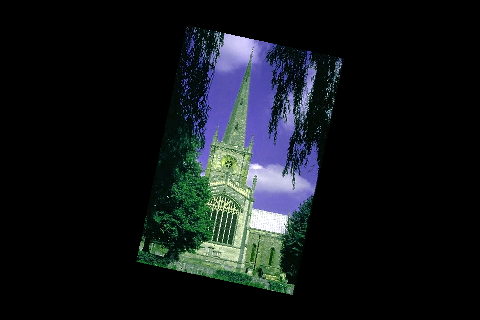

In [6]:
raw, comp = train_dataset[0]
raw = raw.numpy().transpose(1, 2, 0)
comp = comp.numpy().transpose(1, 2, 0)

Image.fromarray((raw * 255).astype(np.uint8))

## Архитектура модели

За основу архитектуры была взята модель Unet, активно использующаяся в задачах сегментации. Она обладает следующими преимуществами
1. Эффективность на небольших наборах данных.

2. Структура "U"-образной сети: Архитектура имеет симметричное U-образное строение, включающее части для кодирования (сжатия) и декодирования (распаковки). Это позволяет эффективно извлекать и восстанавливать пространственные характеристики изображения.

3. Переходные слои и пропуски связей: U-Net использует пропускающие соединения (skip connections), которые позволяют передавать детали с уровней кодирования на соответствующие уровни декодирования. Это помогает сохранять пространственную информацию.

4. Хорошая локальная контекстуализация: Использование операций свертки и объединения позволяет U-Net работать эффективно с локальными и глобальными контекстами, что улучшает качество сегментации.

5. Простое и эффективное обучение: Благодаря своей архитектуре и подходу U-Net часто быстрее обучается и требует меньше ресурсов по сравнению с более сложными моделями, такими как некоторые версии ResNet или DenseNet.

![alt text](unet_arch.jpeg)

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.ops import DeformConv2d


class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Encoder
        self.encoder1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=9, padding=4),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.encoder2 = self.conv_block(32, 64)
        self.encoder3 = self.conv_block(64, 128)
        self.encoder4 = self.conv_block(128, 256)


        # Decoder
        self.decoder4 = self.upconv_block2(256, 128)
        self.decoder3 = self.upconv_block(128, 64)
        self.decoder2 = self.upconv_block(64, 32)
        self.decoder1 = nn.Conv2d(64, 3, kernel_size=3, padding=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def upconv_block2(self, in_channels, out_channels,output_padding=0):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, output_padding=output_padding),
            nn.ReLU(inplace=True),
        )
    
    def upconv_block(self, in_channels, out_channels,output_padding=0):
        return nn.Sequential(
            nn.Conv2d(2*in_channels, in_channels, kernel_size=3, padding=1),
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, output_padding=output_padding),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        # Encoder
        e1 = self.encoder1(x)
        e2 = self.encoder2(F.max_pool2d(e1, kernel_size=2))
        e3 = self.encoder3(F.max_pool2d(e2, kernel_size=2))
        e4 = self.encoder4(F.max_pool2d(e3, kernel_size=2))

        # Decoder
        d4 = self.decoder4(e4)
        d4 = torch.cat((d4, e3), dim=1)
        d3 = self.decoder3(d4)
        d3 = torch.cat((d3, e2), dim=1)
        d2 = self.decoder2(d3)
        d2 = torch.cat((d2, e1), dim=1)
        d1 = self.decoder1(d2)
        # Final Convolution
        out = x + d1
        return out

    
unet = UNet(3, 3)
unet(torch.ones(1, 3, 320, 480)).shape

torch.Size([1, 3, 320, 480])

## Обучение

Код по обучению представлен в приложении 1

## Тестирование

In [ ]:
unet.load_state_dict(torch.load('unet_best.pth', weights_only=True))
unet.eval()

device = torch.device('mps')
unet.to(device)

h = 320
w = 480


def cal_psnr(img_orig, img_out):
    squared_error = np.square(img_orig - img_out)
    mse = np.mean(squared_error)
    psnr = 10 * np.log10(1.0 / mse)
    return psnr


def yuv2rgb (Y,U,V,fw,fh):
    U_new = cv2.resize(U, (fw, fh),cv2.INTER_CUBIC)
    V_new = cv2.resize(V, (fw, fh), cv2.INTER_CUBIC)
    U = U_new
    V = V_new
    Y = Y
    rf = Y + 1.4075 * (V - 128.0)
    gf = Y - 0.3455 * (U - 128.0) - 0.7169 * (V - 128.0)
    bf = Y + 1.7790 * (U - 128.0)

    for m in range(fh):
        for n in range(fw):
            if (rf[m, n] > 255):
                rf[m, n] = 255
            if (gf[m, n] > 255):
                gf[m, n] = 255
            if (bf[m, n] > 255):
                bf[m, n] = 255
            if (rf[m, n] < 0):
                rf[m, n] = 0
            if (gf[m, n] < 0):
                gf[m, n] = 0
            if (bf[m, n] < 0):
                bf[m, n] = 0
    r = rf
    g = gf
    b = bf
    return r, g, b


def GetRGBFrame (folderyuv,VideoNumber,FrameNumber,fw,fh):
    fwuv = fw // 2
    fhuv = fh // 2
    Y = np.zeros((fh, fw), np.uint8, 'C')
    U = np.zeros((fhuv, fwuv), np.uint8, 'C')
    V = np.zeros((fhuv, fwuv), np.uint8, 'C')

    dir_list = os.listdir(folderyuv)
    v=0
    for name in dir_list:
        fullname = folderyuv + name
        if v!=VideoNumber:
            v = v + 1
            continue
        if fullname.endswith('.yuv'):
            fp = open(fullname, 'rb')
            fp.seek(0, 2)  # move the cursor to the end of the file
            size = fp.tell()
            fp.close()
            fp = open(fullname, 'rb')
            frames = (2 * size) // (fw * fh * 3)
            for f in range(frames):
                for m in range(fh):
                    for n in range(fw):
                        Y[m, n] = ord(fp.read(1))
                for m in range(fhuv):
                    for n in range(fwuv):
                        U[m, n] = ord(fp.read(1))
                for m in range(fhuv):
                    for n in range(fwuv):
                        V[m, n] = ord(fp.read(1))
                if f==FrameNumber:
                    r, g, b = yuv2rgb(Y, U, V, fw, fh)
                    return r,g,b
                
def ShowFramePSNRPerformance (folderyuv,foldercomp,VideoIndex,framesmax,fw,fh):
    RGBRAW = np.zeros((h, w, 3))
    RGBCOMP = np.zeros((h, w, 3))
    dir_list = os.listdir(folderyuv)
    v = 0
    l = []
    for name in dir_list:
        fullname = folderyuv + name
        print(name)
        if v != VideoIndex:
            v = v + 1
            continue
        if fullname.endswith('.yuv'):
            fp = open(fullname, 'rb')
            fp.seek(0, 2)  # move the cursor to the end of the file
            size = fp.tell()
            fp.close()
            frames = (2 * size) // (fw * fh * 3)
            if frames>framesmax:
                frames = framesmax

            PSNRCOMP = np.zeros((frames))
            PSNRUNET = np.zeros((frames))
            for f in range(frames):
                r, g, b = GetRGBFrame(folderyuv, VideoIndex, f, w, h)
                RGBRAW[:, :, 0] = r
                RGBRAW[:, :, 1] = g
                RGBRAW[:, :, 2] = b
                r, g, b = GetRGBFrame(foldercomp, VideoIndex, f, w, h)
                RGBCOMP[:, :, 0] = r
                RGBCOMP[:, :, 1] = g
                RGBCOMP[:, :, 2] = b
                PSNRCOMP[f] = cal_psnr(RGBRAW / 255.0, RGBCOMP / 255.0)
                
                out = unet(torch.from_numpy(RGBCOMP / 255.0).unsqueeze(0).permute(0, 3, 1, 2).to(device, torch.float).to(device, torch.float)).permute(0, 2, 3, 1)[0]
                out = out.cpu().detach().numpy()
                PSNRUNET[f] = cal_psnr(RGBRAW / 255.0, out)
        
        return PSNRCOMP, PSNRUNET


PSNRCOMP, PSNRUNET = ShowFramePSNRPerformance(testfolderRawYuv,testfolderCompYuv,0,100,w,h)


Так как тензорфлоу не очень хорошо устаналивается на MacOs, то результаты исходной модели я сохранил в файле (запускал в Google Colab)

In [142]:
PSNRENCH = np.load('ench_psnr.npy')

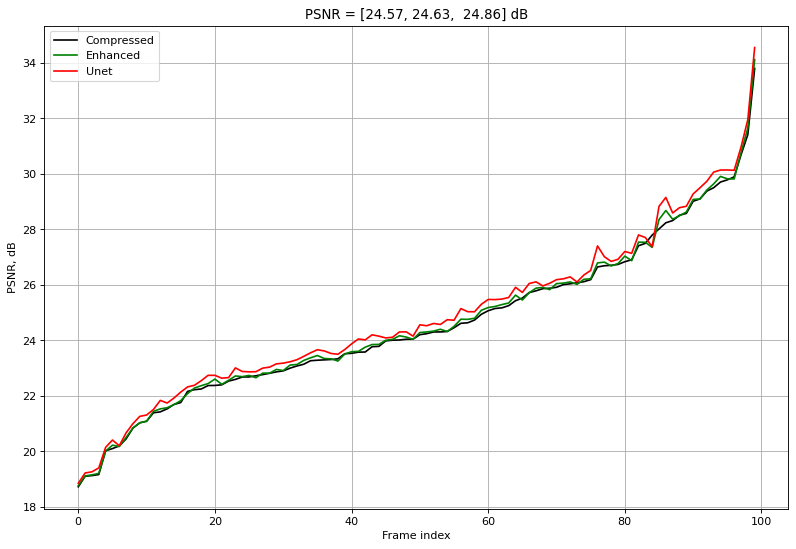

In [144]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(12, 8), dpi=80)

ind = np.argsort(PSNRCOMP)

plt.plot(PSNRCOMP[ind], label='Compressed', color='black')
plt.plot(PSNRENCH[ind], label='Enhanced', color='green')
plt.plot(PSNRUNET[ind], label='Unet', color='red')
plt.xlabel('Frame index')
plt.ylabel('PSNR, dB')
plt.grid()
plt.legend()
tit = "PSNR = [%.2f, %.2f,  %.2f] dB" % (np.mean(PSNRCOMP), np.mean(PSNRENCH), np.mean(PSNRUNET))
plt.title(tit)
plt.show()

In [145]:
print(f"Средний PSNR исходной модели - {sum(PSNRENCH) / len(PSNRENCH)}")
print(f"Средний PSNR UNET модели - {sum(PSNRUNET) / len(PSNRUNET)}")
print(f"Средняя разница между моделями - {sum(PSNRUNET) / len(PSNRUNET) - sum(PSNRENCH) / len(PSNRENCH)}")

Средний PSNR исходной модели - 24.632644778894388
Средний PSNR UNET модели - 24.857654931676148
Средняя разница между моделями - 0.22501015278175984


## Приложение 1. Обучение

In [ ]:
device = torch.device("mps")

model = UNet(3, 3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.MSELoss()
model.to(device)

In [ ]:
best_loss = 100
# model.load_state_dict(torch.load('best_model.pth', weights_only=True))

for _ in range(200):
    # Train
    running_loss = 0.0
    model.train()
    
    for xraw, xcomp in train_dataloader:
        batch = xcomp.to(device, torch.float)
        labels = xraw.to(device, torch.float)

        optimizer.zero_grad()

        predictions = model(batch)
        loss = loss_fn(predictions, labels)

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * batch.size(0)
    
    print("Train loss", running_loss / len(Xraw))
    
    # Eval
    running_loss = 0.0
    model.eval()
    with torch.no_grad():
        for i in range(0, len(XrawVal), batch_size):
            batch = torch.from_numpy(XcompVal[i:i+batch_size]).permute(0, 3, 1, 2).to(device, torch.float)
            labels = torch.from_numpy(XrawVal[i:i+batch_size]).permute(0, 3, 1, 2).to(device, torch.float)

            predictions = model(batch)
            loss = loss_fn(predictions, labels)

            running_loss += loss.item() * batch.size(0)
    
    print("Val loss", running_loss / len(XrawVal))
    if best_loss > running_loss / len(XrawVal):
        torch.save(model.state_dict(), 'best_model.pth')
        best_loss = running_loss / len(XrawVal)